In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:

import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble    import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Prepare Data

## Import

In [3]:
def wrangle(path):
    #import data
    df=pd.read_csv(path)
    # drop irrelevant columns
    df.drop(columns=['PassengerId','Name','Ticket','Cabin'], inplace=True)
    # impute age null values
    df['Age']=df[['Age','Pclass']].apply(impAge, axis=1)
    # drop na
    df.dropna(inplace=True)
    return df
    

In [4]:
df=pd.read_csv('/kaggle/input/titanic/train.csv')
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Explore

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
missing_data=df.isnull().sum()/len(df)
missing_data

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

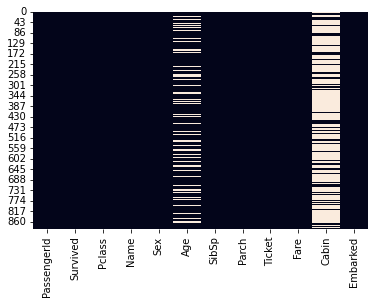

In [8]:
sns.heatmap(df.isnull(), cbar=False);

Three columns have missing data  
Age: will be fixed by imputing the mean  
Cabin:more than 70% is missing. So it will be dropped  
Embarked: can drop the rows


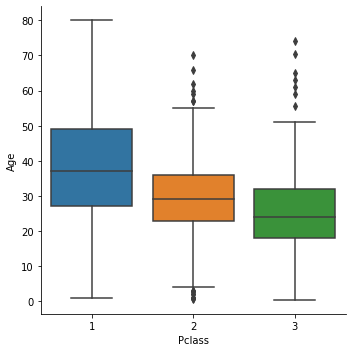

In [9]:
sns.catplot(data=df, x="Pclass", y="Age", kind="box");

In [10]:
# age of passengers in different classes
df.groupby('Pclass')['Age'].median()

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64

In [11]:
def impAge(X):
    Age=X[0]
    Pclass=X[1]
    
    if pd.isnull(Age):
        if Pclass==1:
            return 37
        elif Pclass==2:
            return 29
        else:
            return 24
    else:
        return Age
    
    

In [12]:
df['Age']=df[['Age','Pclass']].apply(impAge, axis=1)

In [13]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [14]:
#drop cabin
df.drop('Cabin', axis=1, inplace=True)

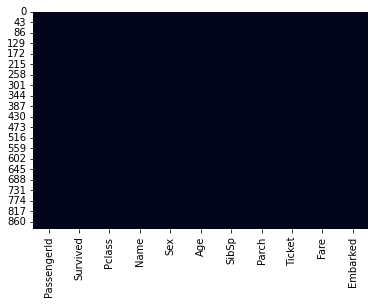

In [15]:
sns.heatmap(df.isnull(), cbar=False);

In [16]:
# drop irrelevant features
df.drop(columns=['Name', 'Ticket','PassengerId'], inplace=True)

In [17]:
# drop na
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


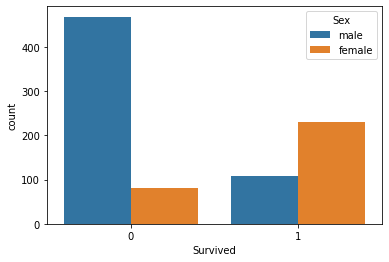

In [18]:
# fraction of those who survived
sns.countplot(data=df, x='Survived', hue='Sex');

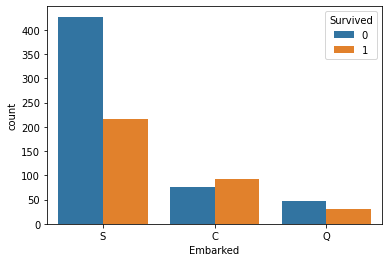

In [19]:
# fraction of those who survived based on where they embarked
sns.countplot(data=df, x='Embarked', hue='Survived');

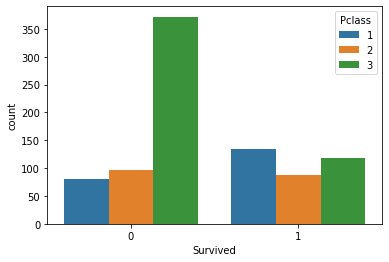

In [20]:
# fraction of those who survived based on the class
sns.countplot(data=df, x='Survived', hue='Pclass');

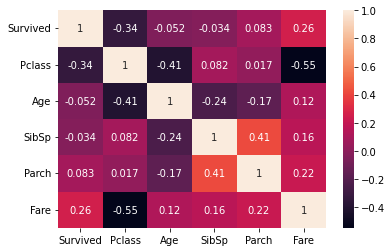

In [21]:
sns.heatmap(df.corr(), annot=True);

## Split

In [22]:
target='Survived'
y=df[target]
X=df.drop(target, axis=1)
print(X.shape, y.shape)

(889, 7) (889,)


In [23]:
X_train,X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.1, random_state=42
)
print(X_train.shape, y_train.shape)

(800, 7) (800,)


# Build Model
## Baseline

In [24]:
# find the majority class
df['Survived'].value_counts(normalize=True).max()

0.6175478065241845

In [25]:
## Train model
model=LogisticRegression(max_iter=1000, verbose=1)
oh=OneHotEncoder(use_cat_names=True)

In [26]:
#convert categorical data
X_train=oh.fit_transform(X_train)
# fit model
model.fit(X_train,y_train)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.54518D+02    |proj g|=  2.90241D+03

At iterate   50    f=  3.62123D+02    |proj g|=  5.40910D+00

At iterate  100    f=  3.59106D+02    |proj g|=  4.37946D+01

At iterate  150    f=  3.57629D+02    |proj g|=  2.69560D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11    189    223      1     0     0   1.060D-01   3.576D+02
  F =   357.62701610037635     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


LogisticRegression(max_iter=1000, verbose=1)

In [27]:
# accuracy
model.score(X_train, y_train)

0.80125

# Evaluate

In [28]:
# test accuracy
X_test=oh.fit_transform(X_test)
model.score(X_test, y_test)
predictions=model.predict(X_test)

[[47 11]
 [ 5 26]]


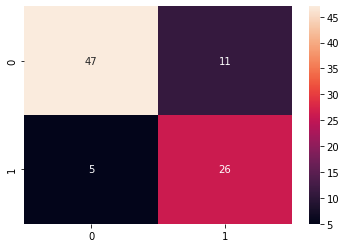

In [29]:
cm=confusion_matrix(y_test, predictions)
print(cm)
sns.heatmap(cm, annot=True);

In [30]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.90      0.81      0.85        58
           1       0.70      0.84      0.76        31

    accuracy                           0.82        89
   macro avg       0.80      0.82      0.81        89
weighted avg       0.83      0.82      0.82        89



## Feature Importance

In [31]:
# features
feat= oh.get_feature_names()
coef= model.coef_[0]
#print(coef)
feat_imp=pd.Series(coef, index=feat).sort_values()
feat_imp

Sex_male     -1.307102
Pclass       -1.192655
SibSp        -0.363588
Embarked_S   -0.191328
Age          -0.044826
Parch        -0.040945
Embarked_Q   -0.035295
Fare          0.001059
Embarked_C    0.224092
Sex_female    1.304572
dtype: float64

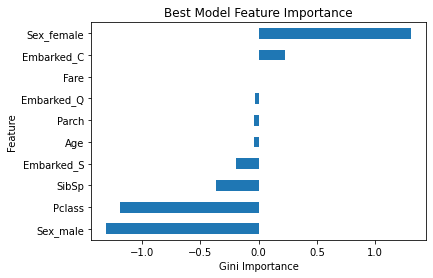

In [32]:
feat_imp.plot(kind='barh')
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Best Model Feature Importance")
plt.savefig('logisticreg_importances');

In [33]:
# import submission files
sub=pd.read_csv('/kaggle/input/titanic/gender_submission.csv')


In [34]:
# import and clean test data
test=wrangle('/kaggle/input/titanic/test.csv')
test.isnull().sum()


Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [35]:
test=oh.fit_transform(test)

In [36]:
y_hat=model.predict(test)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
